In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.02

klin =0

nband = 320

ng =10

ng_refs = (/ 3 , 2 , 5 /) 

nref =3

nv = 50

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 20

data w_diffuse
     &     /1.6 , 1.8 , 1.8 , 1.8,
     &     1.7 , 1.6 , 1.4 , 1.4,
     &     1.7 , 1.8/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6 , 0.6/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

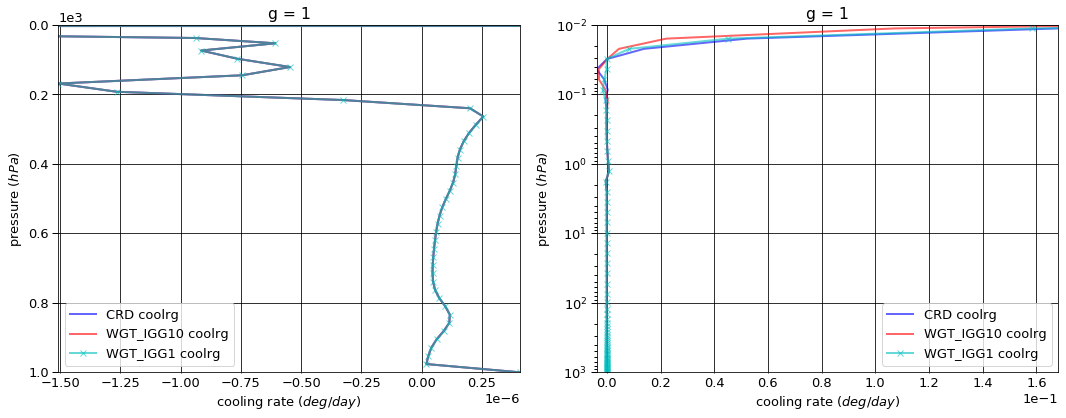

# Figure: cooling rate g-group 2

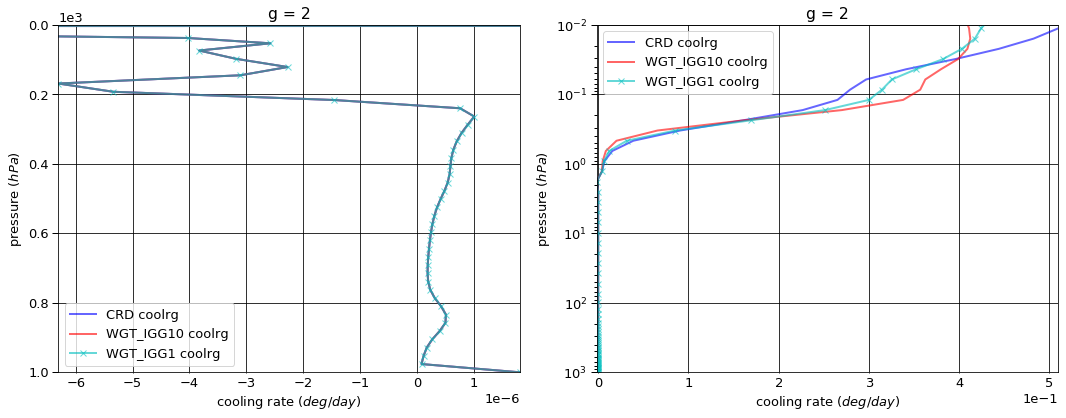

# Figure: cooling rate g-group 3

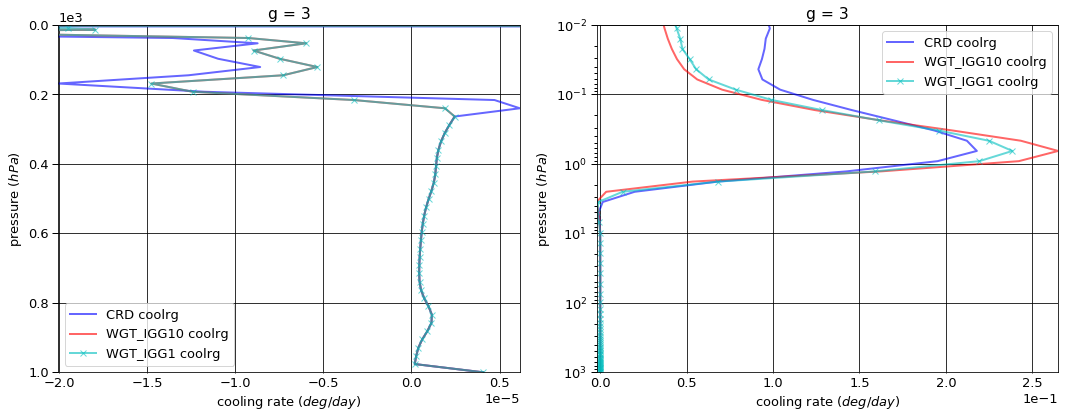

# Figure: cooling rate g-group 4

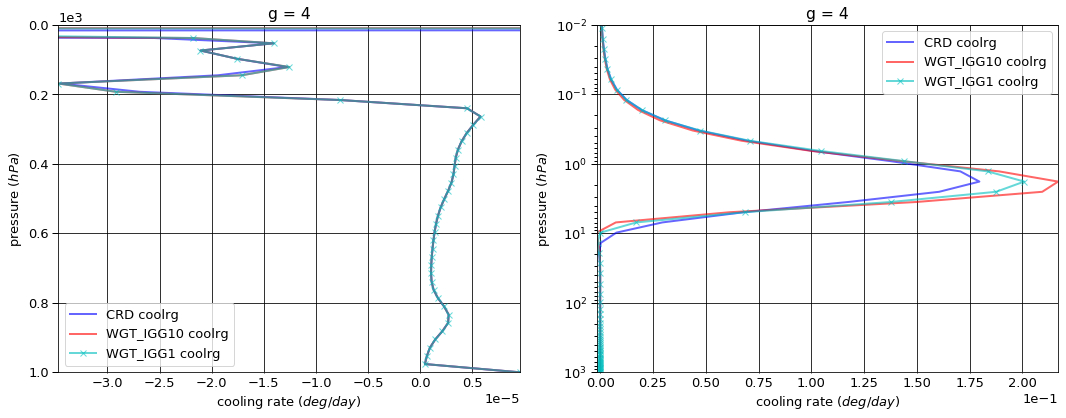

# Figure: cooling rate g-group 5

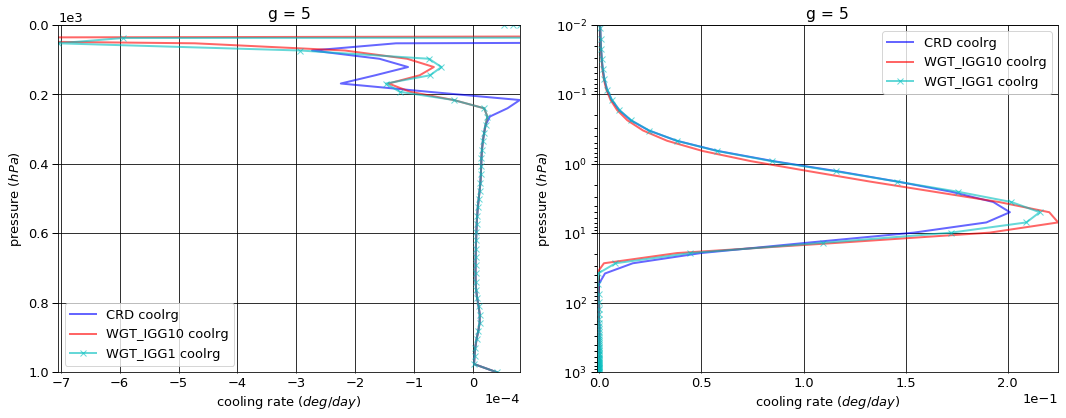

# Figure: cooling rate g-group 6

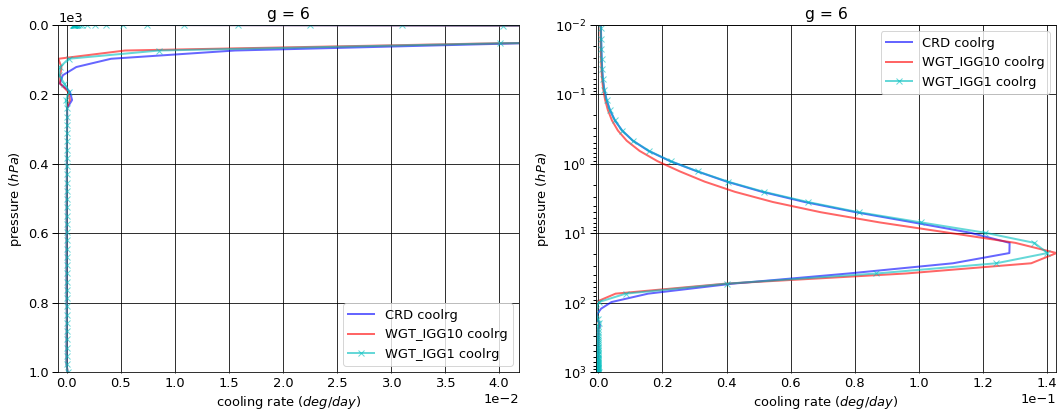

# Figure: cooling rate g-group 7

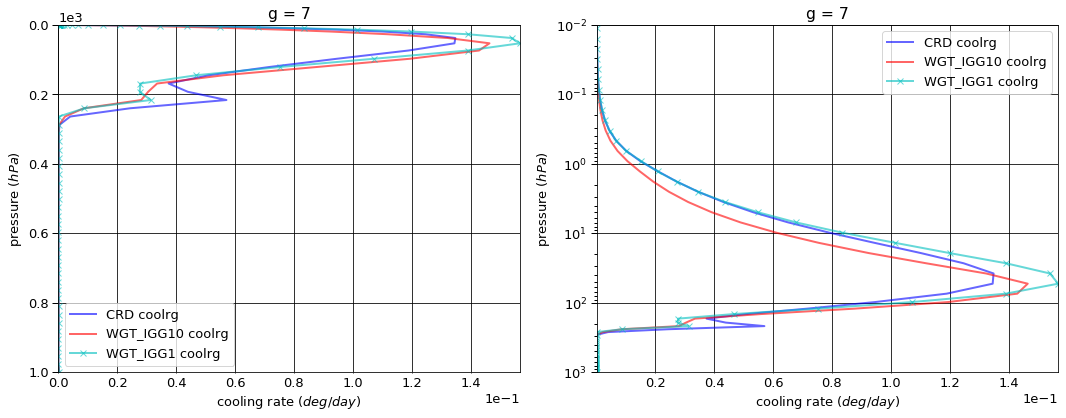

# Figure: cooling rate g-group 8

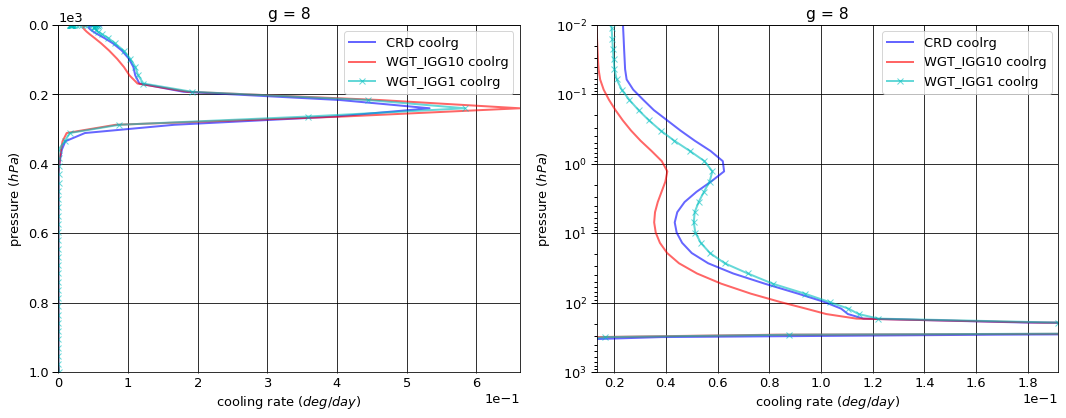

# Figure: cooling rate g-group 9

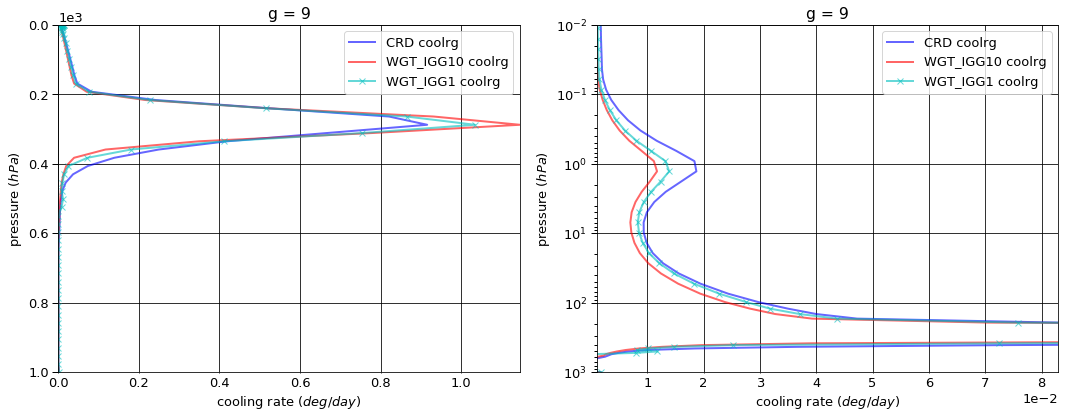

# Figure: cooling rate g-group 10

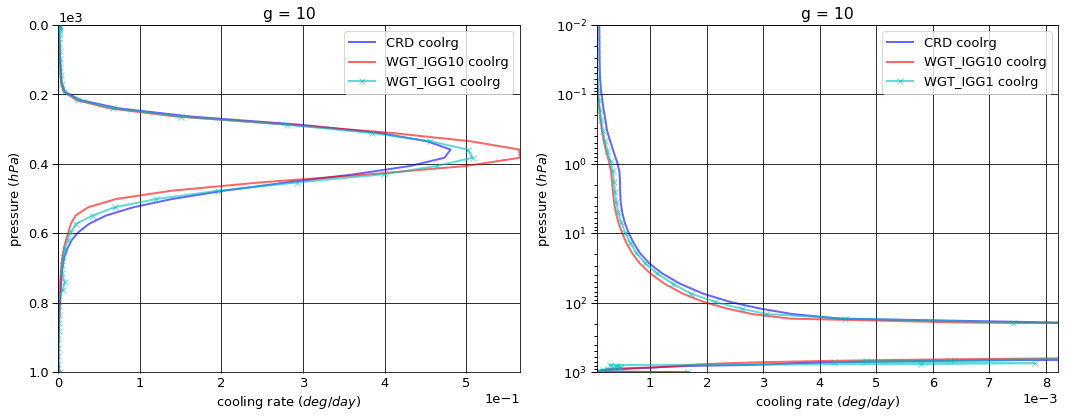

# Figure: cooling rate g-group total

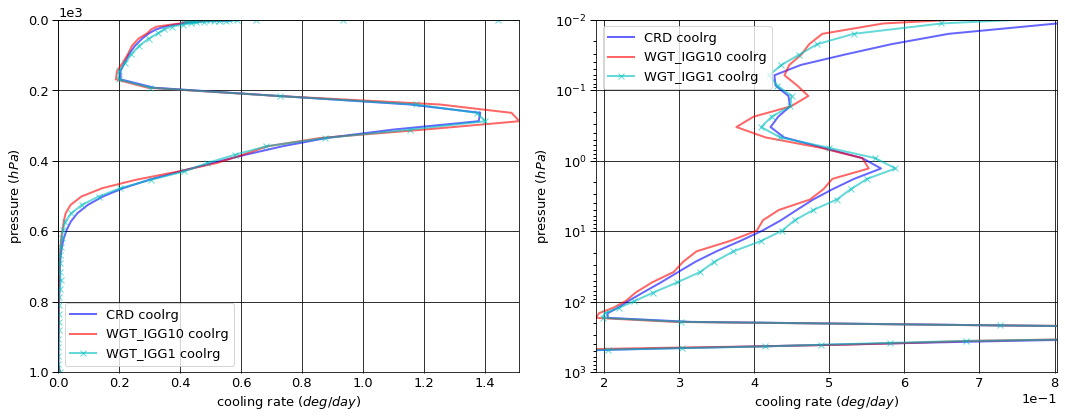

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.002841   0.000000  -0.002841
   1013.0   76     -0.004856   0.004855  -0.000001
2  0.0      1      -0.011146   0.000000  -0.011146
   1013.0   76     -0.018234   0.018229  -0.000005
3  0.0      1      -0.037363   0.000000  -0.037363
   1013.0   76     -0.045875   0.045864  -0.000011
4  0.0      1      -0.088179   0.000000  -0.088179
   1013.0   76     -0.108753   0.108726  -0.000026
5  0.0      1      -0.331865   0.000000  -0.331865
   1013.0   76     -0.460636   0.460523  -0.000113
6  0.0      1      -0.660144   0.000000  -0.660144
   1013.0   76     -1.021991   1.021742  -0.000249
7  0.0      1      -2.254098   0.000000  -2.254098
   1013.0   76     -3.705859   3.704949  -0.000910
8  0.0      1      -6.851251   0.000000  -6.851251
   1013.0   76    -10.879986  10.877301  -0.002685
9  0.0      1     -12.510468   0.000000 -12.510468
   1013.0   76    -18.618525  18.613811  -0.004714
10 0.0      1     -11.482136   0.000000 -11.482136
   1013.0   76    -16.208714  16.204087  -0.004628


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.002842   0.000000  -0.002842
   1013.0   76     -0.004856   0.004855  -0.000001
2  0.0      1      -0.011066   0.000000  -0.011066
   1013.0   76     -0.018234   0.018229  -0.000005
3  0.0      1      -0.037954   0.000000  -0.037954
   1013.0   76     -0.045875   0.045864  -0.000011
4  0.0      1      -0.089858   0.000000  -0.089858
   1013.0   76     -0.108753   0.108726  -0.000026
5  0.0      1      -0.334671   0.000000  -0.334671
   1013.0   76     -0.460636   0.460523  -0.000113
6  0.0      1      -0.661777   0.000000  -0.661777
   1013.0   76     -1.021991   1.021742  -0.000249
7  0.0      1      -2.236458   0.000000  -2.236458
   1013.0   76     -3.705859   3.704949  -0.000910
8  0.0      1      -6.833827   0.000000  -6.833827
   1013.0   76    -10.879986  10.877301  -0.002685
9  0.0      1     -12.424550   0.000000 -12.424550
   1013.0   76    -18.618525  18.613811  -0.004714
10 0.0      1     -11.389943   0.000000 -11.389943
   1013.0   76    -16.208714  16.204098  -0.004616


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.002842   0.000000  -0.002842
   1013.0   76     -0.004856   0.004855  -0.000001
2  0.0      1      -0.011211   0.000000  -0.011211
   1013.0   76     -0.018234   0.018229  -0.000005
3  0.0      1      -0.037925   0.000000  -0.037925
   1013.0   76     -0.045875   0.045864  -0.000011
4  0.0      1      -0.089307   0.000000  -0.089307
   1013.0   76     -0.108753   0.108726  -0.000026
5  0.0      1      -0.334142   0.000000  -0.334142
   1013.0   76     -0.460636   0.460523  -0.000113
6  0.0      1      -0.663538   0.000000  -0.663538
   1013.0   76     -1.021991   1.021742  -0.000249
7  0.0      1      -2.248654   0.000000  -2.248654
   1013.0   76     -3.705859   3.704949  -0.000910
8  0.0      1      -6.805817   0.000000  -6.805817
   1013.0   76    -10.879986  10.877301  -0.002685
9  0.0      1     -12.447636   0.000000 -12.447636
   1013.0   76    -18.618525  18.613811  -0.004714
10 0.0      1     -11.460561   0.000000 -11.460561
   1013.0   76    -16.208714  16.204098  -0.004616


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1     -1.821000e-07  0.000000e+00 -1.821000e-07
   1013.0   76     0.000000e+00  8.673617e-19  2.117582e-22
2  0.0      1      7.968000e-05  0.000000e+00  7.968000e-05
   1013.0   76     0.000000e+00  0.000000e+00  8.470329e-22
3  0.0      1     -5.901770e-04  0.000000e+00 -5.901770e-04
   1013.0   76     0.000000e+00  0.000000e+00 -1.694066e-21
4  0.0      1     -1.679427e-03  0.000000e+00 -1.679427e-03
   1013.0   76     0.000000e+00  0.000000e+00 -3.388132e-21
5  0.0      1     -2.805850e-03  0.000000e+00 -2.805850e-03
   1013.0   76     0.000000e+00  0.000000e+00  1.355253e-20
6  0.0      1     -1.632850e-03  0.000000e+00 -1.632850e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      1.764040e-02  0.000000e+00  1.764040e-02
   1013.0   76     0.000000e+00  0.000000e+00 -1.084202e-19
8  0.0      1      1.742450e-02  0.000000e+00  1.742450e-02
   1013.0   76     0.000000e+00  0.000000e+00 -4.336809e-19
9  0.0      1      8.591800e-02  0.000000e+00  8.591800e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
10 0.0      1      9.219300e-02  0.000000e+00  9.219300e-02
   1013.0   76     0.000000e+00  1.100000e-05  1.160550e-05


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1     -5.130000e-07  0.000000e+00 -5.130000e-07
   1013.0   76     0.000000e+00  8.673617e-19  2.117582e-22
2  0.0      1     -6.460500e-05  0.000000e+00 -6.460500e-05
   1013.0   76     0.000000e+00  0.000000e+00  8.470329e-22
3  0.0      1     -5.614230e-04  0.000000e+00 -5.614230e-04
   1013.0   76     0.000000e+00  0.000000e+00 -1.694066e-21
4  0.0      1     -1.128143e-03  0.000000e+00 -1.128143e-03
   1013.0   76     0.000000e+00  0.000000e+00 -3.388132e-21
5  0.0      1     -2.277650e-03  0.000000e+00 -2.277650e-03
   1013.0   76     0.000000e+00  0.000000e+00  1.355253e-20
6  0.0      1     -3.393360e-03  0.000000e+00 -3.393360e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      5.444400e-03  0.000000e+00  5.444400e-03
   1013.0   76     0.000000e+00  0.000000e+00 -1.084202e-19
8  0.0      1      4.543450e-02  0.000000e+00  4.543450e-02
   1013.0   76     0.000000e+00  0.000000e+00 -4.336809e-19
9  0.0      1      6.283200e-02  0.000000e+00  6.283200e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
10 0.0      1      2.157500e-02  0.000000e+00  2.157500e-02
   1013.0   76     0.000000e+00  1.100000e-05  1.160550e-05

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.092779e+01
   1001.112500 75     4.067544e-07
2  0.000312    1      5.346742e-01
   1001.112500 75     1.813180e-06
3  0.000312    1      8.834541e-02
   1001.112500 75     4.066018e-06
4  0.000312    1      2.264346e-05
   1001.112500 75     9.550412e-06
5  0.000312    1      5.035481e-05
   1001.112500 75     4.071377e-05
6  0.000312    1      6.505584e-04
   1001.112500 75     9.015301e-05
7  0.000312    1      1.812689e-04
   1001.112500 75     3.291985e-04
8  0.000312    1      2.117818e-02
   1001.112500 75     9.708283e-04
9  0.000312    1      1.378979e-03
   1001.112500 75     1.704725e-03
10 0.000312    1      8.690340e-05
   1001.112500 75     1.673520e-03


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      8.783001e+00
   1001.112500 75     4.067544e-07
2  0.000312    1      3.519731e-01
   1001.112500 75     1.813180e-06
3  0.000312    1      2.883415e-02
   1001.112500 75     4.066018e-06
4  0.000312    1      2.000164e-05
   1001.112500 75     9.550412e-06
5  0.000312    1      4.809573e-05
   1001.112500 75     4.071377e-05
6  0.000312    1      5.281427e-04
   1001.112500 75     9.015301e-05
7  0.000312    1      1.289652e-04
   1001.112500 75     3.291985e-04
8  0.000312    1      1.193896e-02
   1001.112500 75     9.708283e-04
9  0.000312    1      8.026419e-04
   1001.112500 75     1.704725e-03
10 0.000312    1      4.533656e-05
   1001.112500 75     1.668778e-03


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      9.633975e+00
   1001.112500 75     4.067544e-07
2  0.000312    1      3.982394e-01
   1001.112500 75     1.813180e-06
3  0.000312    1      3.495145e-02
   1001.112500 75     4.066018e-06
4  0.000312    1      2.191816e-05
   1001.112500 75     9.550412e-06
5  0.000312    1      5.343183e-05
   1001.112500 75     4.071377e-05
6  0.000312    1      6.309586e-04
   1001.112500 75     9.015301e-05
7  0.000312    1      1.782180e-04
   1001.112500 75     3.291985e-04
8  0.000312    1      1.721266e-02
   1001.112500 75     9.708283e-04
9  0.000312    1      9.670341e-04
   1001.112500 75     1.704725e-03
10 0.000312    1      5.084792e-05
   1001.112500 75     1.668778e-03


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.144792e+00
   1001.112500 75     5.293956e-23
2  0.000312    1     -1.827011e-01
   1001.112500 75     0.000000e+00
3  0.000312    1     -5.951126e-02
   1001.112500 75    -8.470329e-22
4  0.000312    1     -2.641827e-06
   1001.112500 75     0.000000e+00
5  0.000312    1     -2.259085e-06
   1001.112500 75    -6.776264e-21
6  0.000312    1     -1.224158e-04
   1001.112500 75     0.000000e+00
7  0.000312    1     -5.230366e-05
   1001.112500 75     0.000000e+00
8  0.000312    1     -9.239224e-03
   1001.112500 75     0.000000e+00
9  0.000312    1     -5.763372e-04
   1001.112500 75     0.000000e+00
10 0.000312    1     -4.156684e-05
   1001.112500 75    -4.742300e-06


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.293818e+00
   1001.112500 75     5.293956e-23
2  0.000312    1     -1.364348e-01
   1001.112500 75     0.000000e+00
3  0.000312    1     -5.339396e-02
   1001.112500 75    -8.470329e-22
4  0.000312    1     -7.253010e-07
   1001.112500 75     0.000000e+00
5  0.000312    1      3.077012e-06
   1001.112500 75    -6.776264e-21
6  0.000312    1     -1.959986e-05
   1001.112500 75     0.000000e+00
7  0.000312    1     -3.050890e-06
   1001.112500 75     0.000000e+00
8  0.000312    1     -3.965519e-03
   1001.112500 75     0.000000e+00
9  0.000312    1     -4.119450e-04
   1001.112500 75     0.000000e+00
10 0.000312    1     -3.605548e-05
   1001.112500 75    -4.742300e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.229492,0.000000,-34.229492
1013.0,76,-51.073429,51.060087,-0.013342



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.022945,0.000000,-34.022945
1013.0,76,-51.073429,51.060098,-0.013331



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.101632,0.000000,-34.101632
1013.0,76,-51.073429,51.060098,-0.013331



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.206547,0.000000,0.206547
1013.0,76,0.000000,0.000011,0.000012



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.12786,0.000000,0.127860
1013.0,76,0.00000,0.000011,0.000012


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,11.574361
1001.112500,75,0.004825



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,9.177321
1001.112500,75,0.004820



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,10.086281
1001.112500,75,0.004820



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.397041
1001.112500,75,-0.000005



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.488080
1001.112500,75,-0.000005


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000125,0.000098
2,0.000313,0.000351
3,0.001000,0.000915
4,0.002687,0.002176
5,0.011000,0.009197
6,0.023375,0.020414
7,0.088188,0.073902
8,0.250437,0.216633
9,0.391250,0.367904


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.372307e-16
2,2.601420e-17
3,2.852660e-18
4,5.740151e-18
5,6.832022e-19
6,7.155529e-19
7,8.793590e-20
8,1.080664e-20
9,1.328052e-21


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.372307e-16,NaN,0.000125,0.000098,0.000125,0.000098,1.0
2,2.601420e-17,0.109658,0.000313,0.000351,0.000438,0.000450,1.0
3,2.852660e-18,0.109658,0.001000,0.000915,0.001437,0.001364,1.0
4,5.740151e-18,2.012210,0.002687,0.002176,0.004125,0.003541,30.0
5,6.832022e-19,0.119022,0.011000,0.009197,0.015125,0.012738,30.0
6,7.155529e-19,1.047351,0.023375,0.020414,0.038500,0.033152,300.0
7,8.793590e-20,0.122892,0.088188,0.073902,0.126688,0.107054,300.0
8,1.080664e-20,0.122892,0.250437,0.216633,0.377125,0.323686,300.0
9,1.328052e-21,0.122892,0.391250,0.367904,0.768375,0.691590,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [27]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     2.442004e-15  1.766810e-15   1.382154  1.677136e-01
      2  0.000312     2.878017e-17  1.925638e-17   1.494579  1.883212e-03
      3  0.000312     2.118338e-18  5.926101e-19   3.574591  8.944719e-05
      4  0.000312     2.985289e-22  2.985235e-22   1.000018  2.542275e-08
      5  0.000312     1.367473e-22  1.357220e-22   1.007554  1.158444e-08
      6  0.000312     6.614797e-22  5.652132e-22   1.170319  5.059366e-08
      7  0.000312     4.564371e-23  3.703019e-23   1.232608  3.593656e-09
      8  0.000312     2.305471e-21  6.332404e-23  36.407522  1.199590e-07
      9  0.000312     8.336643e-23  4.616658e-24  18.057745  4.417012e-09
      10 0.000312     7.396719e-24  3.197099e-25  23.135721  3.888386e-10
2     1  0.000750     2.439044e-15  1.766852e-15   1.380446  6.752338e-02
      2  0.000750     2.897678e-17  1.938484e-17   1.494816  7.636406e-04
      3  0.000750     2.127419e-18  5.968613e-19   3.564344  3.622366e-05
      4  0.000750     6.827719e-22  6.827442e-22   1.000041  2.341962e-08
      5  0.000750     1.733769e-22  1.723077e-22   1.006206  5.921462e-09
      6  0.000750     6.667164e-22  5.700308e-22   1.169615  2.054801e-08
      7  0.000750     4.646448e-23  3.780988e-23   1.228898  1.475067e-09
      8  0.000750     2.306931e-21  6.350806e-23  36.325015  4.835048e-08
      9  0.000750     8.390410e-23  4.641547e-24  18.076755  1.790521e-09
      10 0.000750     7.400878e-24  3.214182e-25  23.025696  1.567280e-10
3     1  0.001052     2.433228e-15  1.767107e-15   1.376955  9.461848e-02
      2  0.001052     2.935706e-17  1.958104e-17   1.499260  1.083013e-03
      3  0.001052     2.141380e-18  6.005639e-19   3.565616  5.112569e-05
      4  0.001052     9.473735e-22  9.473203e-22   1.000056  4.557096e-08
      5  0.001052     2.005538e-22  1.994147e-22   1.005712  9.609148e-09
      6  0.001052     6.726441e-22  5.750578e-22   1.169698  2.907106e-08
      7  0.001052     4.720534e-23  3.846461e-23   1.227241  2.102594e-09
      8  0.001052     2.309998e-21  6.372011e-23  36.252256  6.789860e-08
      9  0.001052     8.502461e-23  4.678447e-24  18.173683  2.544052e-09
      10 0.001052     7.409434e-24  3.238061e-25  22.882317  2.200860e-10
4     1  0.001476     2.427008e-15  1.767315e-15   1.373275  1.326234e-01
      2  0.001476     2.976915e-17  1.980144e-17   1.503384  1.538105e-03
      3  0.001476     2.157076e-18  6.053696e-19   3.563239  7.226862e-05
      4  0.001476     1.318102e-21  1.317999e-21   1.000078  8.894749e-08
      5  0.001476     2.378604e-22  2.366361e-22   1.005174  1.599421e-08
      6  0.001476     6.797838e-22  5.812433e-22   1.169534  4.122031e-08
      7  0.001476     4.815539e-23  3.932261e-23   1.224624  3.011342e-09
      8  0.001476     2.313271e-21  6.397402e-23  36.159539  9.539380e-08
      9  0.001476     8.623647e-23  4.720421e-24  18.268810  3.619233e-09
      10 0.001476     7.418517e-24  3.265655e-25  22.716784  3.091992e-10
5     1  0.002070     2.420673e-15  1.767438e-15   1.369594  1.858441e-01
      2  0.002070     3.019529e-17  2.004292e-17   1.506532  2.185427e-03
      3  0.002070     2.174270e-18  6.116313e-19   3.554871  1.022661e-04
      4  0.002070     1.837610e-21  1.837411e-21   1.000108  1.739235e-07
      5  0.002070     2.891482e-22  2.878205e-22   1.004613  2.728100e-08
      6  0.002070     6.883445e-22  5.888491e-22   1.168966  5.856209e-08
      7  0.002070     4.937780e-23  4.045149e-23   1.220667  4.335833e-09
      8  0.002070     2.316581e-21  6.427615e-23  36.041069  1.339975e-07
      9  0.002070     8.747951e-23  4.767069e-24  18.350797  5.148650e-09
      10 0.002070     7.427668e-24  3.296966e-25  22.528801  4.343170e-10
6     1  0.002904     2.414180e-15  1.767457e-15   1.365906  2.604337e-01
      2  0.002904     3.063929e-17  2.031381e-17   1.508298  3.108443e-03
      3  0.002904     2.193537e

# Histogram of wavenumbers in g-group 1

In [28]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [29]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
